In [6]:
import pandas as pd
import requests
import json
from sentence_transformers import SentenceTransformer
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from matplotlib.patches import FancyBboxPatch


self_defined_tags = [
    'information retrieval',
    'deep learning, neural networks',
    'big data, large-scale data processing',
    'Twitter, real-time search and filtering',
    'question answering, document summarization',
    'natural language processing, computational linguistics',
    'reproducibility, evaluation issues and methodology',
    'information seeking, user interaction, visualization',
    'medical and biomedical informatics',
    'computational social science, digital humanities',
    'hydrology, water sciences'
]

# self_defined_tags = [
#     'Human-Computer Interaction',
#     'Gesture Recognition',
#     'Design',
#     'Computational Theory',
#     'Collaboration',
#     'Document',
# ]

In [1]:
url = 'https://api.semanticscholar.org/graph/v1/author/1401678555/papers'
query_params = {'fields': 'paperId,title,abstract,venue,citationCount,referenceCount,url,year,authors.name', 'limit': 1000}
api_key = 'J43ICmWkaxa1Y84qFr0u7948ut6zDei72zN4kzWz'
headers = {'x-api-key': api_key}


papers = []


response = requests.get(url, params=query_params, headers=headers)

if response.status_code == 200:
    response_data = response.json()
    papers.extend(response_data['data'])
else:
    print(f"Request failed with status code {response.status_code}: {response.text}")

with open('../raw_data/michele_papers.json', 'w') as f:
    json.dump(papers, f)

In [252]:
# read the JSON file
with open('../raw_data/michele_papers.json', 'r') as f:
    papers = json.load(f)
    
# Print the number of papers
print(f"Number of papers: {len(papers)}")

Number of papers: 183


In [253]:
df = pd.DataFrame(papers)
df.to_csv('../raw_data/michele_papers.csv', index=False)
df.head()

,paperId,url,title,abstract,venue,year,referenceCount,citationCount,authors
0,0f8597d3b6279d5f68cd90e1987029336e9ba940,https://www.semanticscholar.org/paper/0f8597d3...,Interaction Knowledge: Understanding the ‘Mech...,User interfaces typically feature tools to act...,International Conference on Human Factors in C...,2023,43,1,"[{'authorId': '1666628811', 'name': 'Miguel A...."
1,299057c27ad8083db9ed2b2f9cddeac8e6cf7335,https://www.semanticscholar.org/paper/299057c2...,Beyond Applications: Interaction Substrates an...,This paper introduces a new interaction model ...,Interaction Homme-Machine,2023,52,0,"[{'authorId': '1401678555', 'name': 'M. Beaudo..."
2,3b0fd8671f6d0724c234c3e5125946b572624d72,https://www.semanticscholar.org/paper/3b0fd867...,Mirrorverse: Live Tailoring of Video Conferenc...,How can we let users adapt video-based meeting...,ACM Symposium on User Interface Software and T...,2023,62,1,"[{'authorId': '1404543550', 'name': 'J. Grønbæ..."
3,47c2eb6383704949e5710e34a5d918efd8dc83aa,https://www.semanticscholar.org/paper/47c2eb63...,Lorgnette: Creating Malleable Code Projections,Projections of computer languages are tools th...,ACM Symposium on User Interface Software and T...,2023,85,0,"[{'authorId': '66701993', 'name': 'Camille Gob..."
4,80b00aa9418dd23485dfaa3f9942e15a93fa79c8,https://www.semanticscholar.org/paper/80b00aa9...,Telepresence Systems for Large Interactive Spaces,The need to analyze and manipulate large datas...,,2023,13,0,"[{'authorId': '2273003369', 'name': 'Cédric Fl..."


In [254]:
# remove duplicates and None values
df = df.drop_duplicates(subset=['title'])
df = df.dropna(subset=['title'])
df = df.dropna(subset=['year'])
df = df.dropna(subset=['abstract'])

In [255]:
model = SentenceTransformer('all-MiniLM-L6-v2')

# embed the abstracts
abstracts = df['abstract'].tolist()
abstract_embeddings = model.encode(abstracts, show_progress_bar=True)
df['abstract_embedding'] = abstract_embeddings.tolist()

# reduce the dimensionality of the embeddings
umap = UMAP(n_components=2)
abstract_embeddings_2d = umap.fit_transform(abstract_embeddings)

# add the embeddings to the DataFrame
df['abstract_embedding_umap_x'] = abstract_embeddings_2d[:, 0]
df['abstract_embedding_umap_y'] = abstract_embeddings_2d[:, 1]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

In [222]:
# # cluster the papers with HDBSCAN
# from hdbscan import HDBSCAN

# clusters = HDBSCAN(min_cluster_size=8, metric='euclidean', cluster_selection_method='eom').fit(abstract_embeddings_2d)

# prob_threshold = 0.05
# cluster_labels = clusters.labels_
# label_count = len(np.unique(cluster_labels))
# total_num = len(clusters.labels_)
# cost = (np.count_nonzero(clusters.probabilities_ < prob_threshold)/total_num)

# print(f"Number of clusters: {label_count}")
# print(f"Number of papers in clusters: {len(clusters.labels_)}")
# print(f"Percentage of papers with low probability: {cost:.2%}")

In [257]:
CLUSTER_COUNT = 8

kmeans = KMeans(n_clusters=CLUSTER_COUNT, random_state=0).fit(abstract_embeddings_2d)
kmeans_labels = kmeans.labels_

df['cluster'] = kmeans_labels


def get_top_keywords_per_cluster(cluster, n_keywords=CLUSTER_COUNT):
    cluster_df = df[df['cluster'] == cluster]
    cluster_abstracts = cluster_df['abstract'].tolist()
    
    count_vectorizer = CountVectorizer(stop_words='english')
    count_data = count_vectorizer.fit_transform(cluster_abstracts)
    
    word_freq = dict(zip(count_vectorizer.get_feature_names_out(), count_data.toarray().sum(axis=0)))
    keywords = sorted(word_freq, key=word_freq.get, reverse=True)
    
    return keywords[:n_keywords]

for cluster in range(CLUSTER_COUNT):
    keywords = get_top_keywords_per_cluster(cluster)
    print(f"Cluster {cluster} Keywords: {', '.join(keywords)}")
    
# store top 3 keywords for each cluster
cluster_keywords = {}
for cluster in range(CLUSTER_COUNT):
    keywords = get_top_keywords_per_cluster(cluster, 3)
    cluster_keywords[cluster] = keywords
    
# add cluster keywords to the DataFrame
df['cluster_keywords'] = df['cluster'].apply(lambda x: ', '.join(cluster_keywords[x]))

Cluster 0 Keywords: interaction, hci, interfaces, computer, research, applications, computers, human
Cluster 1 Keywords: document, navigation, documents, perspective, users, camera, experiment, wall
Cluster 2 Keywords: users, chi, process, webstrates, work, user, community, software
Cluster 3 Keywords: users, video, interaction, large, collaboration, remote, support, sized
Cluster 4 Keywords: design, designers, tools, use, context, interaction, based, prototyping
Cluster 5 Keywords: interaction, user, objects, interface, graphical, interfaces, based, development
Cluster 6 Keywords: interaction, design, gesture, gestures, bayesian, information, based, computer
Cluster 7 Keywords: pointing, target, techniques, fitts, law, selection, performance, user


/Users/r4yen/miniconda3/envs/llm-sys/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [273]:
tag_embeddings = model.encode(self_defined_tags)

# one data might have multiple tags, so we need to calculate the similarity of each data with each tag
tag_similarities = cosine_similarity(abstract_embeddings, tag_embeddings)

df['tags'] = [
    sorted(
        [tag for tag, score in zip(self_defined_tags, similarity_scores) if score > 0.4],
        key=lambda tag: next(score for t, score in zip(self_defined_tags, similarity_scores) if t == tag),
        reverse=True
    ) if max(similarity_scores) > 0.4
    else [self_defined_tags[np.argmax(similarity_scores)]]
    for similarity_scores in tag_similarities
]

ValueError: Length of values (141) does not match length of index (478)

In [11]:
df = pd.read_csv('../data/jimmy_papers_with_embeddings.csv')

df['tags'] = df['tags'].apply(ast.literal_eval)

In [12]:
# find unique combinations of tags
unique_tag_combinations = set(tuple(tags) for tags in df['tags'])
tag_combination_counts = {tags: 0 for tags in unique_tag_combinations}

for tags in df['tags']:
    tag_combination_counts[tuple(tags)] += 1
    
tag_combination_counts = {tags: count for tags, count in tag_combination_counts.items() if count > 1}

# sort the tag combinations by count
sorted_tag_combinations = sorted(tag_combination_counts.items(), key=lambda x: x[1], reverse=True)

# print the top 10 tag combinations
for tags, count in sorted_tag_combinations[:10]:
    print(f"{tags}: {count}")

('information retrieval',): 117
('question answering, document summarization',): 75
('Twitter, real-time search and filtering',): 47
('question answering, document summarization', 'information retrieval'): 45
('big data, large-scale data processing',): 36
('information retrieval', 'question answering, document summarization'): 32
('deep learning, neural networks',): 26
('natural language processing, computational linguistics',): 23
('Twitter, real-time search and filtering', 'information retrieval'): 11
('reproducibility, evaluation issues and methodology',): 9


/var/folders/v7/wpbns06j4k916t2k95n8wkvm0000gn/T/ipykernel_62813/3644702652.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(self_defined_tags))


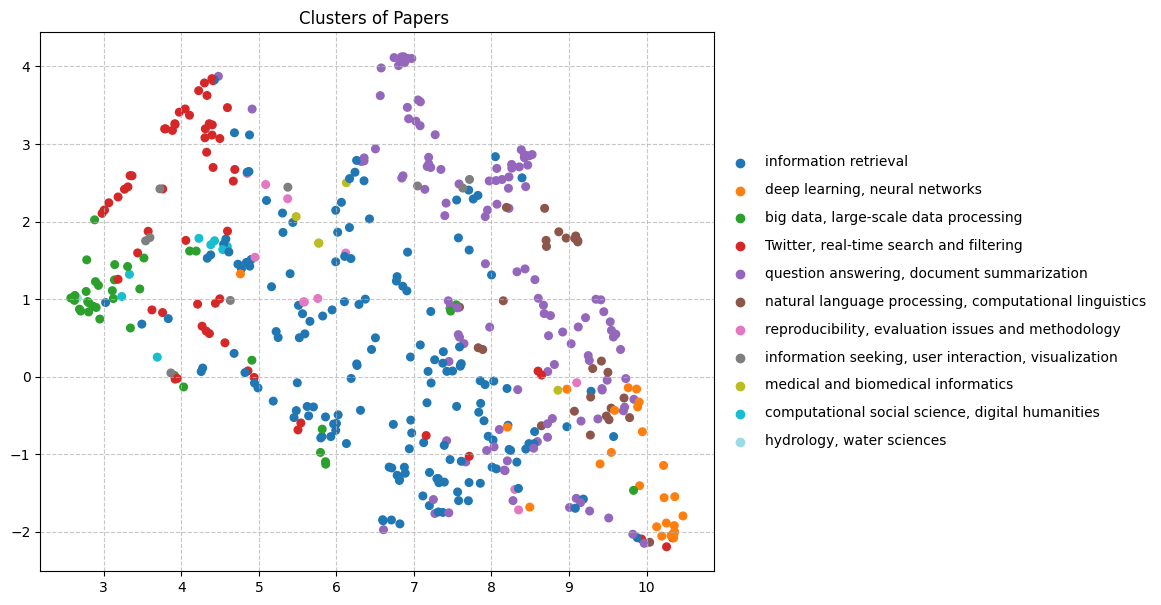

In [13]:
colors = plt.cm.get_cmap('tab20', len(self_defined_tags))
# colors = sns.color_palette('tab20', len(self_defined_tags))

plt.figure(figsize=(12, 7))
# hue is tags, a list of tags, get the first one in the list
plt.scatter(df['abstract_embedding_umap_x'], df['abstract_embedding_umap_y'], c=[colors(self_defined_tags.index(tags[0])) for tags in df['tags']], s=30)

plt.title('Clusters of Papers ')

# add legend
for i, tag in enumerate(self_defined_tags):
    plt.scatter([], [], c=[colors(i)], label=tag)
    
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, loc='center left', bbox_to_anchor=(1, 0.5))
plt.gca().set_aspect('equal', 'box')
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.show()

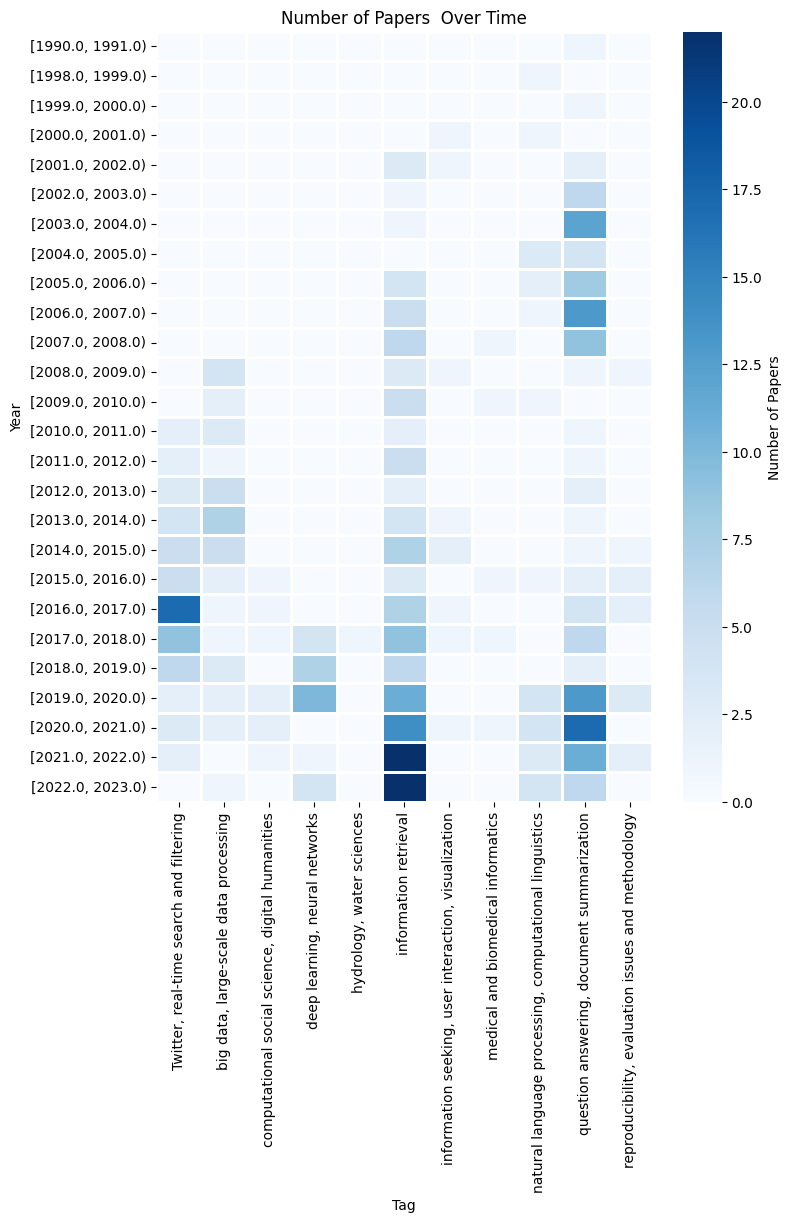

In [14]:
df['year_bin'] = pd.cut(df['year'], bins=np.arange(np.min(df['year']), np.max(df['year']) + 1, 1), right=False)

# count the number of papers in each sorted_tag_combinations
tag_counts = {tags: 0 for tags, _ in sorted_tag_combinations}

# heatmap
plt.figure(figsize=(8, 10))
sns.heatmap(
    pd.crosstab(df['year_bin'], df['tags'].apply(lambda x: x[0])),
    cmap='Blues',
    cbar_kws={'label': 'Number of Papers'},
    linewidths=1
)

plt.title('Number of Papers  Over Time')
plt.xlabel('Tag')
plt.ylabel('Year')
plt.show()

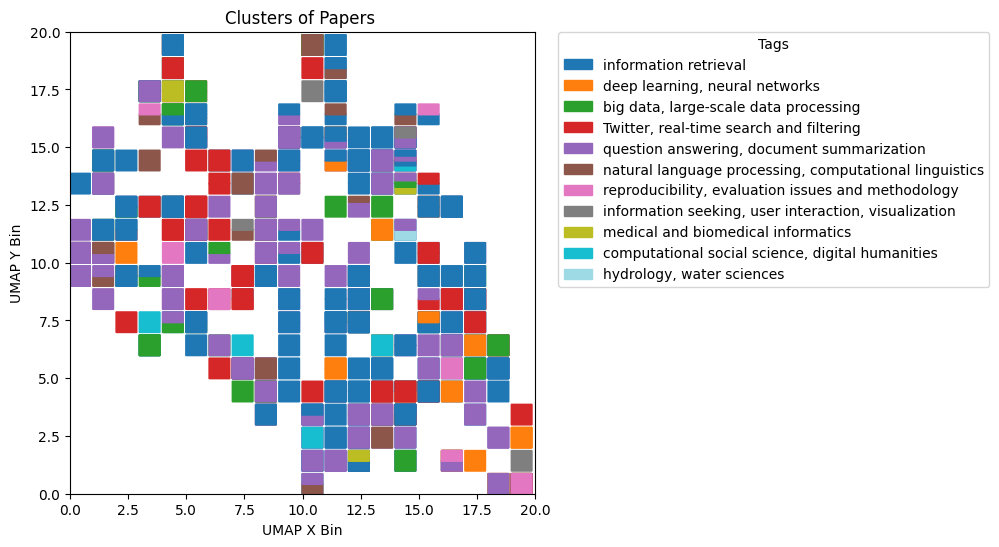

In [15]:
BINS_NUM = 20

df['umap_x_bin'] = pd.cut(df['abstract_embedding_umap_x'], bins=BINS_NUM, labels=False)
df['umap_y_bin'] = pd.cut(df['abstract_embedding_umap_y'], bins=BINS_NUM, labels=False)

# Create a dictionary mapping each tag to a color
tag_to_color = {tag: colors(i) for i, tag in enumerate(self_defined_tags)}

# Create a figure and a subplot
fig, ax = plt.subplots(figsize=(6, 6))

# Initialize an empty list to store the patches
patch_list = []

# Iterate over the rows of the DataFrame
for _, row in df.iterrows():
    # Get the x and y bin values
    x_bin, y_bin = row['umap_x_bin'], row['umap_y_bin']
    
    # Get the tags for the current data point
    tags = row['tags']
    
    # If there are no tags, create a single white patch for the current data point
    if not tags:
        patch = FancyBboxPatch(
            (x_bin, y_bin), .85, .85, boxstyle='round,pad=0.05', ec='black', fc='white'
        )
        patch_list.append(patch)
    else:
        # If there are tags, create a patch for each tag
        patch_height = .85 / len(tags)
        for i, tag in enumerate(tags):
            color = tag_to_color[tag]
            patch = FancyBboxPatch(
                (x_bin, y_bin + i * patch_height), .85, patch_height, boxstyle='round,pad=0.05', ec='black', fc=color
            )
            patch_list.append(patch)

# Create a PatchCollection from the list of patches
p = PatchCollection(patch_list)

# Set the face color of the patches based on the tags
p.set_facecolor(df['tags'].apply(lambda x: tag_to_color[x[0]] if x else 'white'))
# p.set_facecolor(df['tags'].apply(lambda tags: np.mean([tag_to_color[tag] for tag in tags], axis=0) if tags else 'white'))

# Add the PatchCollection to the subplot
ax.add_collection(p)

# Set the limits of the subplot
ax.set_xlim(0, BINS_NUM)
ax.set_ylim(0, BINS_NUM)

# Set the title and labels of the subplot
ax.set_title('Clusters of Papers ')
ax.set_xlabel('UMAP X Bin')
ax.set_ylabel('UMAP Y Bin')


# legend
legend_patches = [patches.Patch(color=color, label=tag) for tag, color in tag_to_color.items()]
plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Tags')
plt.show()

In [16]:
# df.to_csv('../data/michele_papers_with_embeddings.csv', index=False)